In [1]:
import importlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils

importlib.reload(paths)
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [2]:
fhr = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/fhr.pickle")
uc = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/uc.pickle")
y = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/y.pickle")

fhr.shape, uc.shape, y.shape

((538, 21620), (538, 21620), (538,))

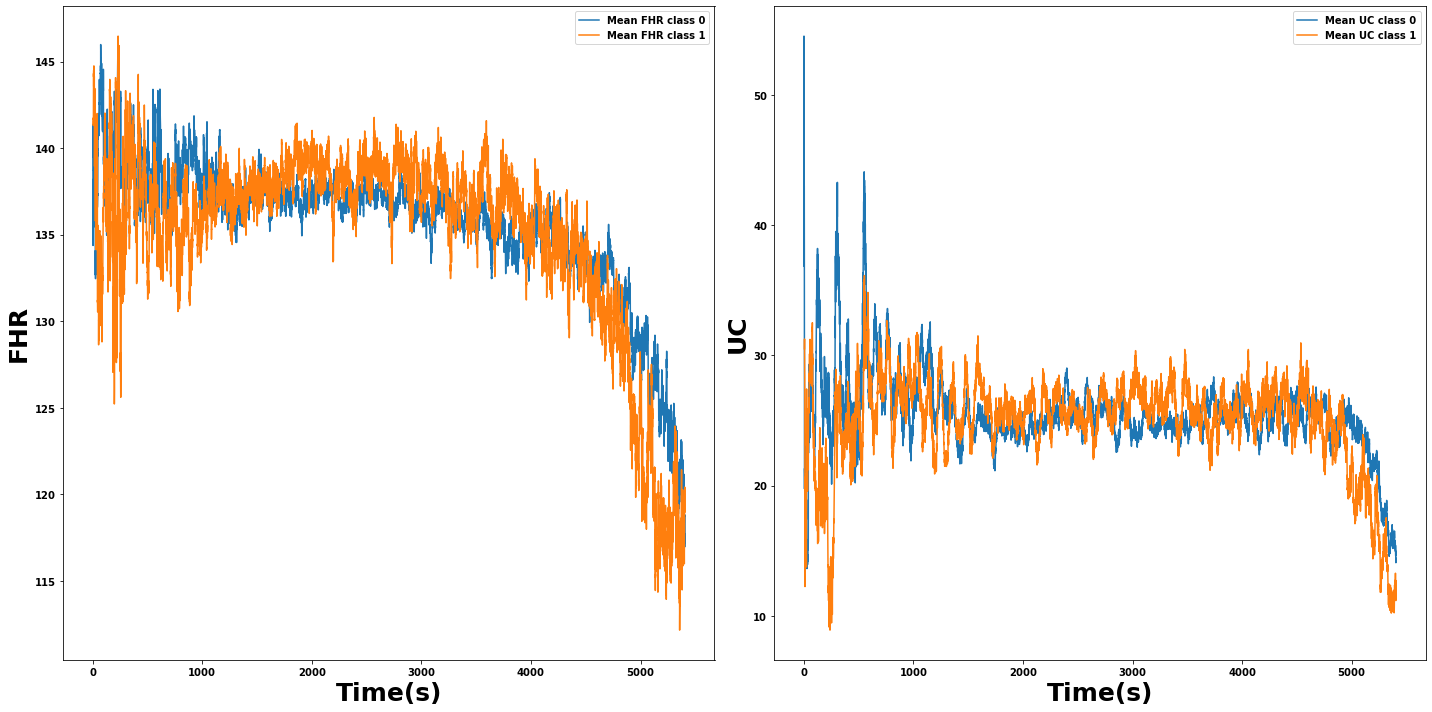

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].plot(fhr[y == 0].mean().index, fhr[y == 0].mean().values, label='Mean FHR class 0')
ax[0].plot(fhr[y == 1].mean().index, fhr[y == 1].mean().values, label='Mean FHR class 1')
ax[1].plot(uc[y == 0].mean().index, uc[y == 0].mean().values, label='Mean UC class 0')
ax[1].plot(uc[y == 1].mean().index, uc[y == 1].mean().values, label='Mean UC class 1')

ax[0].set_xlabel('Time(s)', fontsize=25)
ax[1].set_xlabel('Time(s)', fontsize=25)
ax[0].set_ylabel('FHR', fontsize=25)
ax[1].set_ylabel('UC', fontsize=25)
ax[0].legend()
ax[1].legend()
fig.tight_layout()


In [4]:
"""
    change constant parts for Nans
"""
threshold = 4 * 5 * 60  # 5 minutos a 4 Hz
for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr.iterrows(), uc.iterrows()), total=len(uc)):
    constant_parts_fhr = [x for x in np.split(fhr_row.index, np.where(np.diff(fhr_row.values) != 0)[0] + 1) if
                          x.size > threshold]
    constant_parts_uc = [x for x in np.split(uc_row.index, np.where(np.diff(uc_row.values) != 0)[0] + 1) if
                         x.size > threshold]

    for constant_part in constant_parts_fhr:
        fhr_row[constant_part] = np.nan

    for constant_part in constant_parts_uc:
        uc_row[constant_part] = np.nan
# 538/538 [07:38<00:00, 1.13it/s]

  0%|          | 0/538 [00:00<?, ?it/s]

In [5]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr.copy().iterrows(), uc.copy().iterrows()), total=len(uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag) for lag in lags
    )
# 538/538 [02:24<00:00, 3.74it/s]

  0%|          | 0/538 [00:00<?, ?it/s]

In [6]:
cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1001,-0.143577,-0.143364,-0.143112,-0.143055,-0.143319,-0.143857,-0.144431,-0.144714,-0.145337,-0.145785,...,-0.069862,-0.070915,-0.072603,-0.074245,-0.075711,-0.076841,-0.077984,-0.079125,-0.080390,-0.081564
1002,0.178051,0.176280,0.174446,0.172253,0.169981,0.167481,0.164781,0.162386,0.160528,0.158412,...,0.100066,0.101839,0.103502,0.105164,0.106661,0.107799,0.108374,0.108542,0.108160,0.107303
1003,-0.230576,-0.230107,-0.229449,-0.228933,-0.228367,-0.227886,-0.227497,-0.227946,-0.228307,-0.228667,...,-0.032916,-0.033872,-0.035257,-0.036443,-0.037736,-0.039171,-0.040615,-0.042018,-0.043399,-0.044658
1004,-0.138497,-0.139430,-0.140665,-0.141749,-0.142704,-0.142830,-0.142254,-0.141767,-0.141244,-0.140130,...,-0.079584,-0.080212,-0.080415,-0.080802,-0.080871,-0.081032,-0.080883,-0.080740,-0.080662,-0.080434
1005,-0.121905,-0.121802,-0.121595,-0.121750,-0.121791,-0.121556,-0.121041,-0.120696,-0.119994,-0.119507,...,0.009162,0.009493,0.010171,0.010696,0.010617,0.010497,0.010338,0.010390,0.010451,0.010272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,-0.068638,-0.067243,-0.065829,-0.064346,-0.062978,-0.061719,-0.060498,-0.059398,-0.058224,-0.057560,...,-0.209855,-0.210246,-0.210503,-0.211309,-0.211807,-0.212266,-0.213027,-0.213783,-0.214986,-0.215639
2043,0.007374,0.006142,0.004517,0.002829,0.001037,-0.000626,-0.001970,-0.002984,-0.004611,-0.006215,...,-0.178921,-0.178776,-0.178597,-0.178450,-0.177884,-0.177448,-0.176855,-0.176449,-0.175893,-0.175490
2044,0.009746,0.009735,0.009070,0.008440,0.007824,0.007105,0.006719,0.005917,0.005915,0.006205,...,0.157561,0.158602,0.159348,0.160350,0.160821,0.161080,0.161083,0.160907,0.161083,0.161616
2045,0.033712,0.032558,0.030776,0.028386,0.025563,0.022178,0.018981,0.015537,0.012145,0.008431,...,0.154791,0.154804,0.154619,0.154299,0.153981,0.153597,0.153066,0.152515,0.151623,0.150766


In [7]:
bad_idx = cc_df.index[cc_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [8]:
tt = np.array(lags)

cc_0 = cc_df.copy()[y == 0]
mean_0 = cc_0.mean().values
std_0 = cc_0.std().values
max_0 = cc_0.max().values
min_0 = cc_0.min().values

cc_1 = cc_df.copy()[y == 1]
mean_1 = cc_1.mean().values
std_1 = cc_1.std().values
max_1 = cc_1.max().values
min_1 = cc_1.min().values

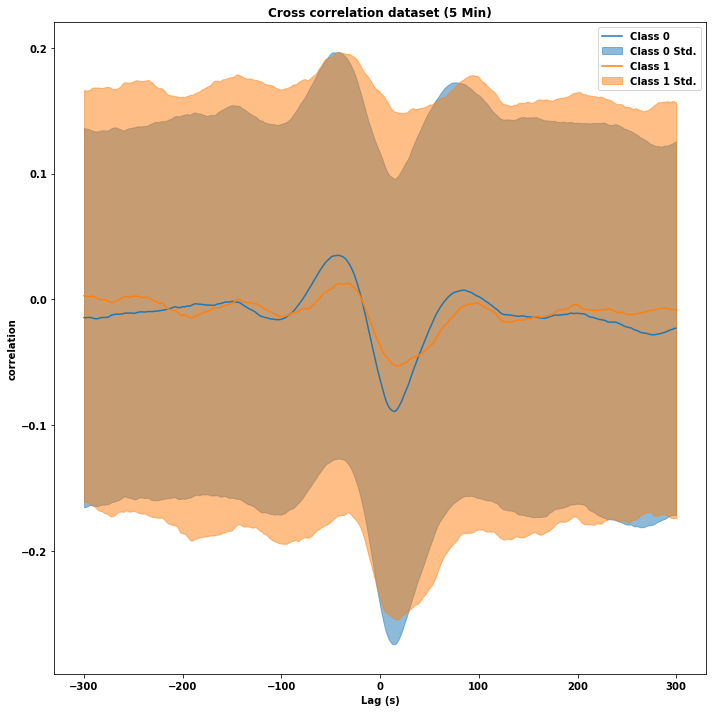

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(tt / 4, mean_0, label='Class 0', color=COLORS[0])
ax.fill_between(tt / 4, mean_0 - std_0, mean_0 + std_0, label='Class 0 Std.', alpha=0.5, color=COLORS[0])

ax.plot(tt / 4, mean_1, label='Class 1', color=COLORS[1])
ax.fill_between(tt / 4, mean_1 - std_1, mean_1 + std_1, label='Class 1 Std.', alpha=0.5, color=COLORS[1])

ax.legend(loc='best')
ax.set_title(f"Cross correlation dataset (5 Min)")
ax.set_ylabel(f"correlation")
ax.set_xlabel("Lag (s)")
fig.tight_layout()

plt.savefig(f"{paths.CC_DATA_PLOTS}/Desc_plot.png")
plt.savefig(f"{paths.CC_DATA_PLOTS}/Desc_plot.pdf")

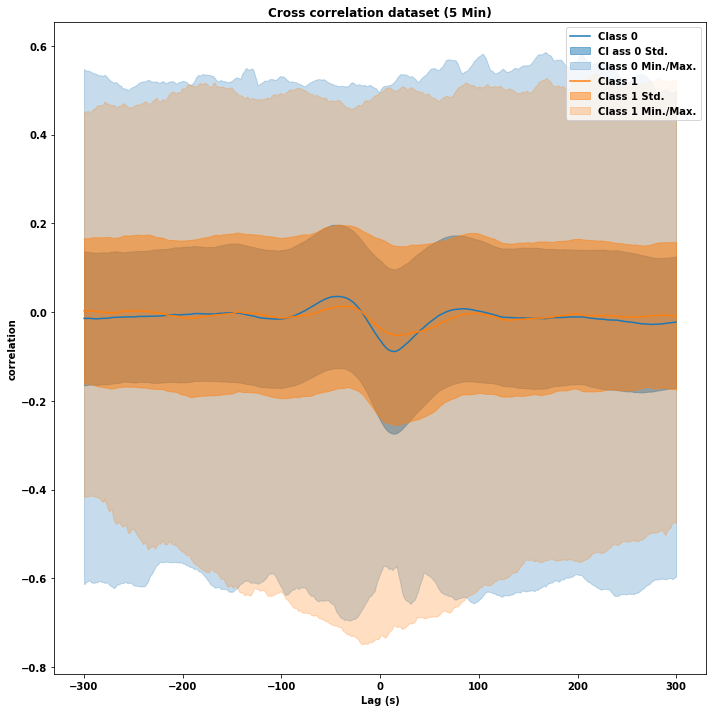

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(tt / 4, mean_0, label='Class 0', color=COLORS[0])
ax.fill_between(tt / 4, mean_0 - std_0, mean_0 + std_0, label='Cl ass 0 Std.', alpha=0.5, color=COLORS[0])
ax.fill_between(tt / 4, min_0, max_0, label='Class 0 Min./Max.', alpha=0.25, color=COLORS[0])

ax.plot(tt / 4, mean_1, label='Class 1', color=COLORS[1])
ax.fill_between(tt / 4, mean_1 - std_1, mean_1 + std_1, label='Class 1 Std.', alpha=0.5, color=COLORS[1])
ax.fill_between(tt / 4, min_1, max_1, label='Class 1 Min./Max.', alpha=0.25, color=COLORS[1])

ax.legend(loc='best')
ax.set_title(f"Cross correlation dataset (5 Min)")
ax.set_ylabel(f"correlation")
ax.set_xlabel("Lag (s)")
fig.tight_layout()

plt.savefig(f"{paths.CC_DATA_PLOTS}/Desc_plot_Mm.png")
plt.savefig(f"{paths.CC_DATA_PLOTS}/Desc_plot_Mm.pdf")

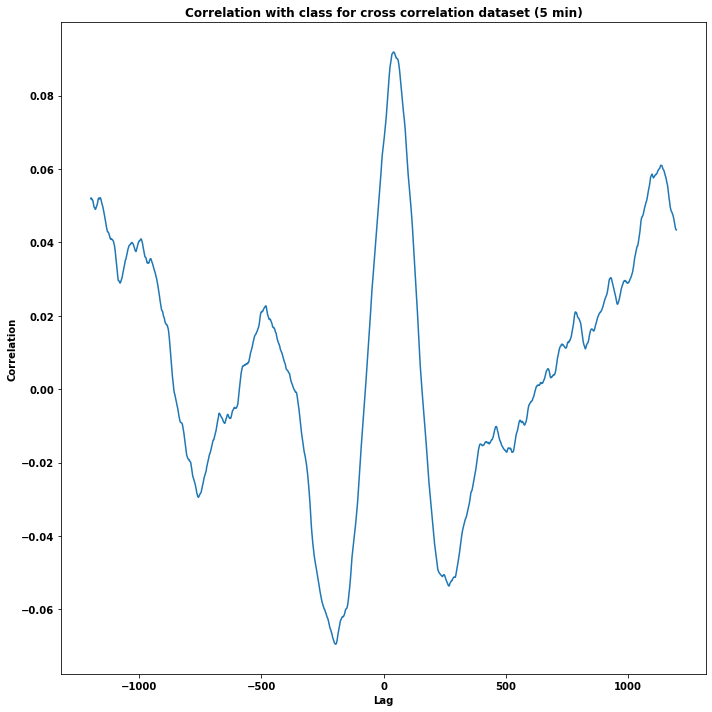

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

cc_df.corrwith(y).plot(ax=ax)

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag')
ax.set_title(f'Correlation with class for cross correlation dataset (5 min)')
fig.tight_layout()

plt.savefig(f"{paths.CC_DATA_PLOTS}/Class_correlation.png")
plt.savefig(f"{paths.CC_DATA_PLOTS}/Class_correlation.pdf")

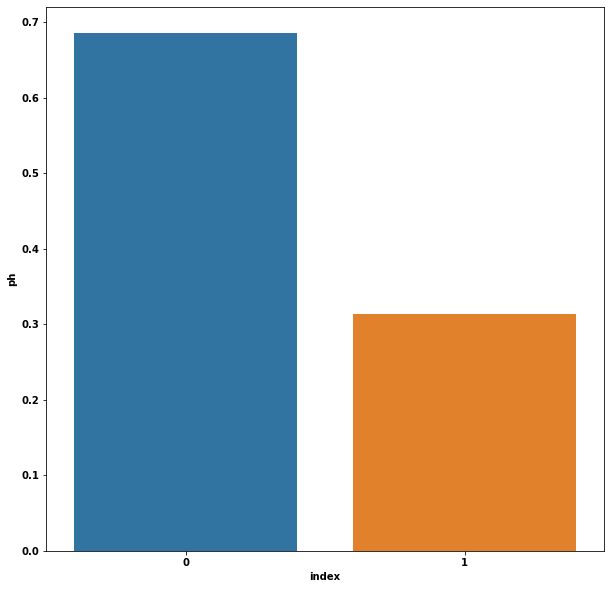

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x='index', y='ph', data=pd.DataFrame(y.value_counts(normalize=True)).reset_index())
plt.savefig(f"{paths.CC_DATA_PLOTS}/Class_Distribution.png")
plt.savefig(f"{paths.CC_DATA_PLOTS}/Class_Distribution.pdf")

In [13]:
cc_df['patologico'] = y

In [14]:
cc_df.to_csv(f"{paths.CC_DATA_PATH}/cc_dataset.csv")

In [15]:
X = cc_df.iloc[:, :-1]
X.to_pickle(f"{paths.CC_DATA_PATH}/X.pickle")
y.to_pickle(f"{paths.CC_DATA_PATH}/y.pickle")